# Stellar-to-halo mass relation

The stellar-to-halo mass relation (SHMR) is one of the fundamental relations when looking at a population of galaxies. It is well known that the evolution and properties of galaxies are strongly correlated to their DM halos. The SHMR is one that is easily available in computer models such as the IllustrisTNG, as the masses of different types of particles are directly part of the simulation.

Here, the SHMR is calculated from the group catalogs of the TNG100-1 run at redshift 0.

In [42]:
import illustris_python as il
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#constants
h = 0.678 #Planck 2015
G = 4.3*10**(-6) #  kpc/M_o*(km/s)**2

The data is read into Python from a premade .csv file containing the relevant subhalos. A halo may include more than one subhalo. The halos with only one subhalo are so called "field-galaxies". The most massive galaxy in a halo is the "central galaxy", the other ones are defined as satellite galaxies.

In [43]:
dfAll = pd.read_pickle("../data/tng100-1/cutdata/Subhalo_MinE9_SM.pkl")
dfCentrals = pd.read_pickle("../data/tng100-1/cutdata/Subhalo_Centrals_minE9_SM.pkl")
sami = pd.read_csv("../data/SAMI/allData.csv")

In [44]:
def dynMass(df, sigmaKey, radiusKey):
    b = 5 #can vary
    df["mass_dynamical"] = b*df[sigmaKey]**2*df[radiusKey]/G
    return df

In [45]:
def doublePowerLaw(b, c, M1, N):
    xmin, xmax = 10**9, 10**14
    dx = 10**10
    x=(np.arange(xmin,xmax,dx))
    y = 2*N*x*((x/M1)**(-b)+(x/M1)**(c))**(-1)
    return x,y

In [46]:
def behroozi():
    a = -1.412
    M1 = 10**(11.514)
    c = 0.316 
    d = 3.508
    e = 10**(-1.78)
    def f(x):
        f = -np.log10(10**(a*x)+1)+d*((np.log10(1+np.exp(x)))**c)/(1+np.exp(10**(-x)))
        return f
    xmin, xmax = 10**9, 10**14
    dx = 10**10
    X=(np.arange(xmin,xmax,dx))/h
    Y = np.log10(e*M1)+f(np.log10(X/M1)) - f(0)
    return X,10**(Y)

In [54]:
def medianValuesLogY(df,type, key1, key2, ymin=9, ymax=12):
    if type == "sami":
        x = df[np.isnan(df[key1]) == False][key1]
        y = df[np.isnan(df[key1]) == False][key2]
    else:
        x = df[key1]
        y = df[key2]
    bins = np.logspace(ymin, ymax, 10)
    medsY = np.zeros(len(bins) -1)
    medsX = np.zeros(len(bins) -1)
    
    for i in range (len(medsY)):
        larger = y[y > bins[i]].index
        smaller = y[y < bins[i+1]].index
        indices = list(set(larger) & set(smaller))
        binlistX = np.zeros(len(indices))
        binlistY = np.zeros(len(indices))
        for j in range(len(indices)):
            binlistX[j] = x[indices[j]]
            binlistY[j] = y[indices[j]]
        #print(binlistX)
        medsX[i] = np.median(binlistX)
        medsY[i] = np.median(binlistY)#(bins[i+1]+bins[i])/2
    
    return medsX, medsY, bins

The first plot will show the SHMR for all the galaxies of the simulation. This includes field-, central- and satellite galaxies. A treshold of $ M_{min} = 10^{9} M_\odot $ has been implemented to restrict the amount of low mass satellite galaxies which will be heavily influenced by their environment, affecting the SHMR. 

We now want to compare our data with others. There have been several studies of the SHMR in galaxy populations, and several attempts at finding the best fit model for the relation. One such is the abundance matching technique used in [Moster et al., 2012](https://arxiv.org/abs/1205.5807). They found a double power law to be a good fit to their data. (INSERT FORMULA)

In [Behroozi et al., 2013](https://arxiv.org/abs/1207.6105), another study also using abundance-matching , it was found that a power law was a good for the low-mass slope, but a subpower law was better for the high-mass end of the relation. Both these fits are presented here, along with the mean values of the TNG100-1 data.

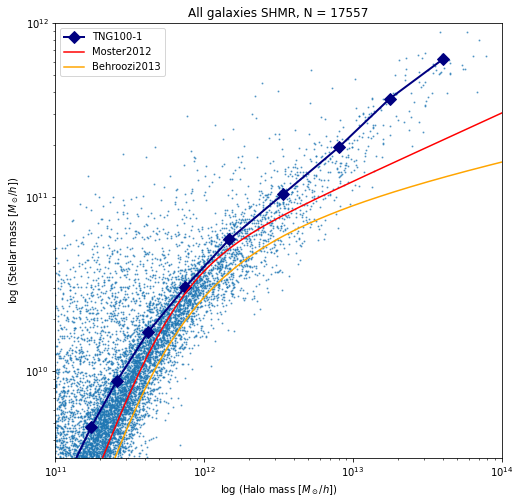

In [48]:
#Calculate mean values
mxTNG, myTNG, bins = medianValuesLogY(dfAll, "tng", "SubhaloMassDM", "SubhaloMassStellar")
#Create the plot
fig1, ax1 = plt.subplots(figsize = (8,8))
dfAll.plot.scatter(x = "SubhaloMassDM", y = "SubhaloMassStellar", s = 1, alpha = 0.6, ax = ax1)
ax1.plot((mxTNG), (myTNG), marker='D', linewidth=2, markersize=8, c="navy", label = "TNG100-1")
#Get double power law fit for Moster 2012
M2012x,M2012y = doublePowerLaw(b = 1.376, c = 0.608,M1 = 10**11.590, N = 0.0351)
ax1.plot((M2012x/h),(M2012y/h), c="red", label= "Moster2012")
#Behroozi fit
B2013x,B2013y = behroozi()
ax1.plot(B2013x,B2013y, c="orange", label= "Behroozi2013")
il.formatplot.HM_SM(title = "All galaxies SHMR", df = dfAll)

It is interesting to separate out the central galaxies and look at their SHMR. Central galaxies are much less affected by their environment as they are the dominant galaxy in their group (if not the only). Thus, central galaxies have properties that are more universal than satellites. Field galaxies have no other galaxies in their group and are therefore even less affected by environmental factors.

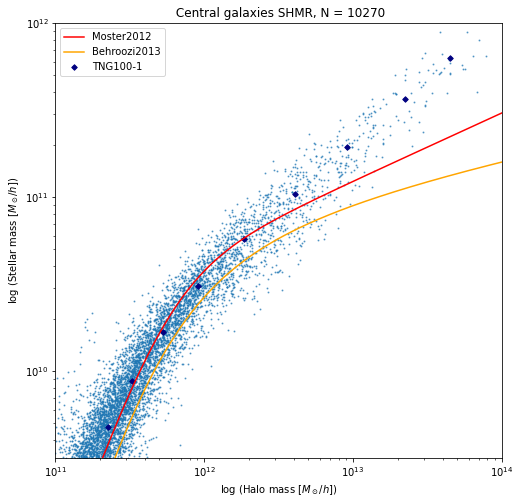

In [49]:
#Calculate mean values
mxTNG, myTNG, bins = medianValuesLogY(dfCentrals, "tng", "SubhaloMassDM", "SubhaloMassStellar")
#Create the plot
fig2, ax2 = plt.subplots(figsize = (8,8))
dfCentrals.plot.scatter(x = "SubhaloMassDM", y = "SubhaloMassStellar", s = 1, alpha = 0.6, ax = ax2)
ax2.scatter(mxTNG, myTNG, marker='D', s=15, color="navy", label = "TNG100-1")
#Get double power law fit for Moster 2012
M2012x,M2012y = doublePowerLaw(b = 1.376, c = 0.608,M1 = 10**11.590, N = 0.0351)
ax2.plot((M2012x/h),(M2012y/h), c="red", label= "Moster2012")
#Behroozi fit
B2013x,B2013y = behroozi()
ax2.plot(B2013x,B2013y, c="orange", label= "Behroozi2013")
il.formatplot.HM_SM(title = " Central galaxies SHMR", df = dfCentrals)


We got a much better fit!

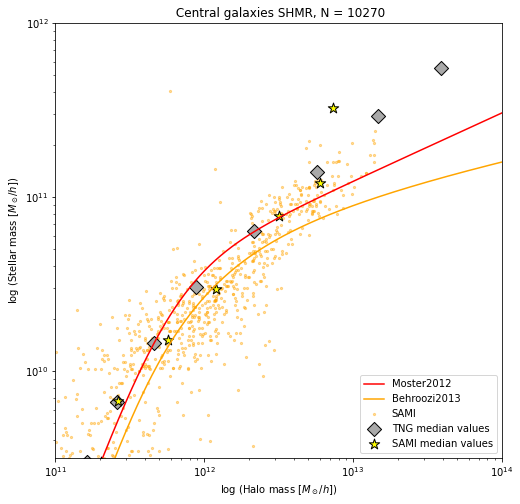

In [58]:
dfCentrals = dynMass(dfCentrals, "SubhaloVelDisp", "SubhaloHalfmassRad")
sami = dynMass(sami, "sigma_re", "r_e")

fig3, ax3 = plt.subplots(figsize = (8,8))
#dfCentrals.plot.scatter(x = "mass_dynamical", y = "SubhaloMassStellar", s = 3, alpha = 0.6, ax = ax3, label = "TNG-100")
sami.plot.scatter(x = "mass_dynamical", y = "mstar", s = 5, alpha = 0.4, ax = ax3, color = "orange", label = "SAMI")
#Get double power law fit for Moster 2012
ax3.plot((M2012x/h),(M2012y/h), c="red", label= "Moster2012")
#Behroozi fit
ax3.plot(B2013x,B2013y, c="orange", label= "Behroozi2013")
#median values
mxTNG, myTNG, bins = medianValuesLogY(dfCentrals, "tng", "mass_dynamical", "SubhaloMassStellar")
mxS, myS, bins = medianValuesLogY(sami, "sami", "mass_dynamical", "mstar")
ax3.scatter(mxTNG, myTNG, marker = "D", label = "TNG median values", s = 100, color = "darkgrey", edgecolors = "black")
ax3.scatter(mxS, myS, marker = "*", label = "SAMI median values", color = "yellow",s = 120, edgecolors = "black")

il.formatplot.HM_SM(title = " Central galaxies SHMR", df = dfCentrals)

In [56]:
print(mxS, myS)

[1.11718417e+11 2.01019685e+11 2.62624566e+11 5.71025710e+11
 1.20200855e+12 3.16629715e+12 6.03470076e+12 7.34215889e+12
            nan] [1.39646090e+09 2.98558047e+09 6.76082975e+09 1.51356125e+10
 2.95120923e+10 7.76247117e+10 1.20226443e+11 3.23631785e+11
            nan]
